In [19]:
import os
from PIL import Image

import torch
from accelerate.logging import get_logger
from diffusers import StableDiffusionPipeline
from diffusers.utils import check_min_version

from peft import PeftModel


# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
check_min_version("0.10.0.dev0")

logger = get_logger(__name__)

MODEL_NAME = "stabilityai/stable-diffusion-2-1"

PEFT_TYPE="hra"
HRA_R=8
SELECTED_SUBJECT="backpack"
EPOCH_IDX = 1000

PROJECT_NAME=f"dreambooth_{PEFT_TYPE}"
RUN_NAME=f"{SELECTED_SUBJECT}_{PEFT_TYPE}_{HRA_R}"
OUTPUT_DIR=f"./data/output/{PEFT_TYPE}"

In [2]:
def get_hra_sd_pipeline(
    ckpt_dir, base_model_name_or_path=None, epoch=int, dtype=torch.float32, device="cuda", adapter_name="default"
):

    if base_model_name_or_path is None:
        raise ValueError("Please specify the base model name or path")

    pipe = StableDiffusionPipeline.from_pretrained(
        base_model_name_or_path, torch_dtype=dtype, requires_safety_checker=False
    ).to(device)
    
    load_adapter(pipe, ckpt_dir, epoch, adapter_name)

    if dtype in (torch.float16, torch.bfloat16):
        pipe.unet.half()
        pipe.text_encoder.half()

    pipe.to(device)
    return pipe


def load_adapter(pipe, ckpt_dir, epoch, adapter_name="default"):
    
    unet_sub_dir = os.path.join(ckpt_dir, f"unet/{epoch}", adapter_name)
    text_encoder_sub_dir = os.path.join(ckpt_dir, f"text_encoder/{epoch}", adapter_name)
    
    if isinstance(pipe.unet, PeftModel):
        pipe.unet.load_adapter(unet_sub_dir, adapter_name=adapter_name)
    else:
        pipe.unet = PeftModel.from_pretrained(pipe.unet, unet_sub_dir, adapter_name=adapter_name)
        
    if os.path.exists(text_encoder_sub_dir):
        if isinstance(pipe.text_encoder, PeftModel):
            pipe.text_encoder.load_adapter(text_encoder_sub_dir, adapter_name=adapter_name)
        else:
            pipe.text_encoder = PeftModel.from_pretrained(pipe.text_encoder, text_encoder_sub_dir, adapter_name=adapter_name)
    

def set_adapter(pipe, adapter_name):
    pipe.unet.set_adapter(adapter_name)
    if isinstance(pipe.text_encoder, PeftModel):
        pipe.text_encoder.set_adapter(adapter_name)

In [16]:
prompt = "a purple qwe backpack."
negative_prompt = "low quality, blurry, unfinished"

In [4]:
%%time
pipe = get_hra_sd_pipeline(OUTPUT_DIR, MODEL_NAME, EPOCH_IDX, adapter_name=RUN_NAME)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 14.47it/s]


CPU times: user 1.72 s, sys: 495 ms, total: 2.22 s
Wall time: 2.28 s


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:09<00:00,  5.28it/s]


CPU times: user 8.77 s, sys: 861 ms, total: 9.63 s
Wall time: 9.6 s


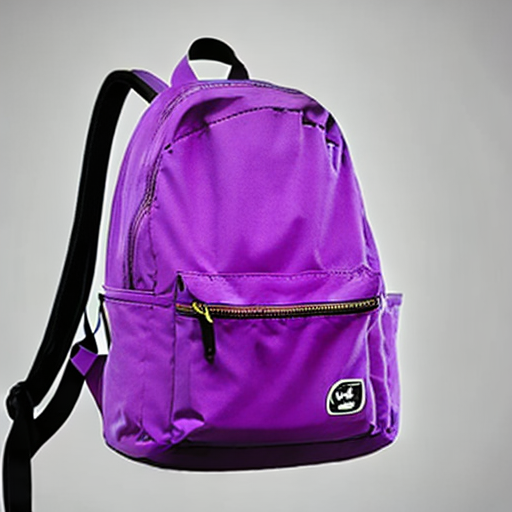

In [23]:
%%time
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5, negative_prompt=negative_prompt).images[0]
image

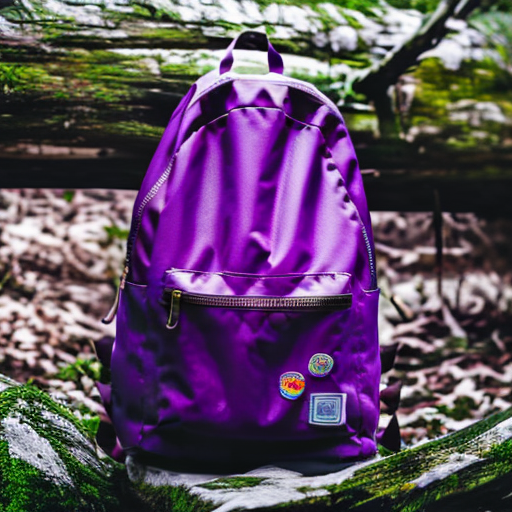

In [20]:
# This is an example.
example_image = Image.open("./a_purple_qwe_backpack.png")
example_image